In [287]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import pandas as pd
import pandas as pd
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

# EDA

In [288]:
df = pd.read_csv("/home/heylucasleao/ols-regression-challenge/data/INFLUD24-03-02-2025.csv", sep=";", encoding="latin1", low_memory=False)

In [289]:
sinais_sintomas = [
    "FEBRE", "TOSSE", "GARGANTA", "DISPNEIA", "DESC_RESP", 
    "SATURACAO", "DIARREIA", "VOMITO", "DOR_ABD", "FADIGA", 
    "PERD_OLFT", "PERD_PALA", "OUTRO_SIN", 
    #"OUTRO_DES"
]
fatores_risco = [
    "FATOR_RISC", 
    #"PUERPERA", 
    "CARDIOPATI", 
    #"HEMATOLOGI", 
    #"SIND_DOWN", 
    #"HEPATICA", 
    "ASMA", 
    "DIABETES", 
    "NEUROLOGIC", 
    "PNEUMOPATI", 
    "IMUNODEPRE", 
    #"RENAL", 
    #"OBESIDADE", 
    #"OBES_IMC", 
    "OUT_MORBI", 
    #"MORB_DESC"
]
vacinacao = [
    "VACINA_COV", 
    #"DOSE_1_COV", 
    #"DOSE_2_COV", 
    #"DOSE_REF", 
    #"DOSE_2REF", 
    #"FAB_COV1", 
    #"FAB_COV2", 
    #"FAB_COVRF", 
    #"FAB_COVRF2", 
    #"LOTE_1_COV", 
    #"LOTE_2_COV", 
    #"LOTE_REF", 
    # "LOTE_REF2", 
    #"FNT_IN_COV"
]
tratamento = [
    "ANTIVIRAL", 
    #"TP_ANTIVIR", "OUT_ANTIV", "DT_ANTIVIR", 
    #"TRAV_COV", 
    #"TIPO_TRAV", 
    #"OUT_TRAV", 
    #"DT_TRAV_COV"
]

internacao = [
    "HOSPITAL", 
    #"DT_INTERNA", 
    #"SG_UF_INTE", 
    #"CO_MU_INTE", 
    #"CO_UN_INTE", 
    "UTI", 
    #"DT_ENTUTI", 
    #"DT_SAIDUTI", 
    "SUPORT_VEN"
]
exames = [
    "RAIOX_RES", 
    #"RAIOX_OUT", 
    #"DT_RAIOX", 
    "TOMO_RES", 
   # "TOMO_OUT", 
    #"DT_TOMO", 
    "AMOSTRA", 
    #"DT_COLETA", 
    "TP_AMOSTRA", 
    #"OUT_AMOST"
]
testes_laboratoriais = [
    "RES_AN", 
    #"POS_AN_FLU", 
    #"TP_FLU_AN", 
    #"POS_AN_OUT", 
    #"AN_SARS2", 
    #"AN_VSR", 
    #"AN_PARA1", 
    #"AN_PARA2", 
    #"AN_PARA3", 
    #"AN_ADENO", 
    #"AN_OUTRO", 
    #"DS_AN_OUT"
]
rt_pcr = [
    "PCR_RESUL", 
    #"DT_PCR", 
    "POS_PCRFLU", 
    #"TP_FLU_PCR", 
    #"PCR_FLUASU", 
    #"FLUASU_OUT", 
    #"PCR_FLUBLI", 
    #"FLUBLI_OUT", 
    "POS_PCROUT",
    #"PCR_SARS2", 
    #"PCR_VSR", 
    #"PCR_PARA1", 
    #"PCR_PARA2", 
    #"PCR_PARA3", 
    #"PCR_PARA4", 
    #"PCR_ADENO", 
    #"PCR_METAP", 
    #"PCR_BOCA", 
    #"PCR_RINO", 
    #"PCR_OUTRO", 
    #"DS_PCR_OUT"
]


In [290]:
columns = (sinais_sintomas 
            + fatores_risco 
            + vacinacao 
            + tratamento 
            + internacao
            + exames
            + testes_laboratoriais
            + rt_pcr)
target = "CASO_SRAG"

In [291]:
df = df[columns + ["CASO_SRAG"]]

In [292]:
is_null = df.isnull().sum()
remove_features = is_null[is_null / len(df) > 0.70].index.tolist()
df = df[df.columns.drop(remove_features)]

In [293]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

IMUNODEPRE    0.695856
NEUROLOGIC    0.691754
PNEUMOPATI    0.691476
ASMA          0.687209
POS_PCRFLU    0.685441
DIABETES      0.676996
POS_PCROUT    0.670232
OUT_MORBI     0.666411
CARDIOPATI    0.658409
TOMO_RES      0.413032
RAIOX_RES     0.311369
OUTRO_SIN     0.273663
PERD_PALA     0.259017
PERD_OLFT     0.257681
DOR_ABD       0.249405
GARGANTA      0.242386
DIARREIA      0.240408
VOMITO        0.233641
FADIGA        0.233330
ANTIVIRAL     0.191679
SATURACAO     0.150790
DESC_RESP     0.119487
DISPNEIA      0.110783
SUPORT_VEN    0.109432
CASO_SRAG     0.109151
FEBRE         0.105394
RES_AN        0.102488
UTI           0.100743
PCR_RESUL     0.078279
TP_AMOSTRA    0.075052
TOSSE         0.065053
HOSPITAL      0.022456
AMOSTRA       0.020666
VACINA_COV    0.000191
FATOR_RISC    0.000000
dtype: float64

In [294]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

# Preprocessing

In [295]:
df = df.fillna(9)
df = df.replace({9: -1})
df = pd.get_dummies(df, columns=df.columns.drop("CASO_SRAG"), drop_first=True)
df = df.astype(int)
df = df[(df["CASO_SRAG"] > -1)]

In [296]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

## Partialling-Out / Residualization (FWL Theorem)

In [297]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_array
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureResidualizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Feature transformer that reduces multicollinearity by residualizing highly correlated features.
    
        For each feature strongly correlated (above `corrcoef` threshold) with others, this class:
        1. Fits a linear regression model using the correlated features as predictors.
        2. Replaces the original feature with residuals (observed - predicted) from the model,
        effectively removing linear dependencies.
        
        Useful as a preprocessing step for linear models where multicollinearity is problematic.
        
        Attributes
        ----------
        models_ : Dict[int, Dict[str, Any]]
            Dictionary storing residualization models for each processed feature.
            Keys are feature indices; values are dicts with:
            - "model": Fitted `LinearRegression` object.
            - "features": Indices of features used as predictors.
        feature_names_in_ : Optional[np.ndarray]
            Names of input features if provided in a pandas DataFrame.
        n_features_in_ : Optional[int]
            Number of features seen during fit.

        Notes
        -----
        - Computes absolute Pearson correlations between all feature pairs (ignoring self-correlations)  
        - Processes features in descending order of total correlation with others  
        - For each target feature:  
          - Selects correlated predictors (≥ threshold) not yet residualized  
          - Fits linear model: target ~ predictors  
          - Replaces target feature with model residuals  
          - Excludes residualized features from future predictor sets  
        - Preserves:  
          - Feature order and non-correlated features  
          - Non-linear relationships  
        - Prevents circular dependencies by marking residualized features  
        - Only removes linear relationships between features  

        """
        self.models_ = None
        self.feature_names_in_ = None
        self.n_features_in_ = None

    def fit(self, X: np.ndarray, corrcoef: float = 0.8):
        """
        Identify feature pairs with absolute correlation ≥ `corrcoef` and prepare residualization models.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data. Can be a pandas DataFrame (preserves column names) or numpy array.
        corrcoef : float, default=0.8
            Absolute correlation threshold for triggering residualization.
            Features with |ρ| ≥ this value will be residualized.
            
        Returns
        -------
        self : FeatureResidualizer
            Fitted transformer.
        """

        self.models_ = {}
        self.feature_names_in_ = getattr(X, 'columns', None)
        X = check_array(X, ensure_2d=True, dtype=np.float64)
        self.n_features_in_ = X.shape[1]
        
        corr = np.abs(np.corrcoef(X, rowvar=False))
        np.fill_diagonal(corr, 0)
        residualized = []

        processing_order = np.argsort(-np.sum(corr, axis=1))

        for i in processing_order:
            corr_feature = corr[i]
            mask = np.ones(corr_feature.shape, dtype=bool)
            mask[residualized] = False
            indexes = np.argwhere((corr_feature >= corrcoef) & mask).flatten()

            if len(indexes) > 0:
                model = LinearRegression()
                model.fit(X[:, indexes], X[:, i])
  
                self.models_[i] = {"model": model,
                                "features": indexes,
                            }
                residualized.append(i)
        
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Apply residualization to the input data using pre-trained models.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Data to transform. Must match feature count of `fit()` input.
            
        Returns
        -------
        X_transformed : ndarray of shape (n_samples, n_features)
            Data with residualized features (others remain unchanged).
            
        Raises
        ------
        ValueError
            If number of features in X doesn't match training data.
        """
        
        check_is_fitted(self, 'models_')
        X = check_array(X, ensure_2d=True, dtype=np.float64)
        X = X.copy()
        
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"Expected {self.n_features_in_} features, got {X.shape[1]}"
            )
        
        for i, model_info in self.models_.items():
            model_info = self.models_[i]
            X[:, i] -= model_info["model"].predict(X[:, model_info["features"]])
            
        return X
    
    def fit_transform(self, X: np.ndarray, corrcoef: float = 0.8) -> np.ndarray:
        """Convenience method for fit().transform()."""
        return self.fit(X, corrcoef=corrcoef).transform(X)

In [ ]:
residualizer = FeatureResidualizer()
residualizer.fit(df_train[df_train.columns.drop("CASO_SRAG")], corrcoef=0.40)

FeatureResidualizer()

### Train Test Split

In [299]:
y_train = df_train["CASO_SRAG"]
y_test = df_test["CASO_SRAG"]
X_train = pd.DataFrame(residualizer.transform(df_train[df_train.columns.drop("CASO_SRAG")]), columns=df_train.columns.drop("CASO_SRAG"))
X_test = pd.DataFrame(residualizer.transform(df_test[df_test.columns.drop("CASO_SRAG")]), columns=df_test.columns.drop("CASO_SRAG"))

### Sinais e Sintomas

In [300]:
def create_residuals_mapping(symptoms_list):
    """
    Cria um dicionário de mapeamento de resíduos onde cada chave é um sintoma
    e o valor é a lista de todos os outros sintomas que ainda não foram incluídos.
    
    Args:
        symptoms_list: Lista de sintomas (ex: sinais_sintomas)
    
    Returns:
        Dicionário no formato {sintoma: [outros_sintomas_restantes]}
    """
    residuals_mapping = {}
    accumulated_exclusions = []
    
    for symptom in symptoms_list:
        predictors = [x for x in symptoms_list if x not in accumulated_exclusions + [symptom]]
        if len(predictors) == 0:
            break
        residuals_mapping[symptom] = predictors
        accumulated_exclusions.append(symptom)
    
    return residuals_mapping

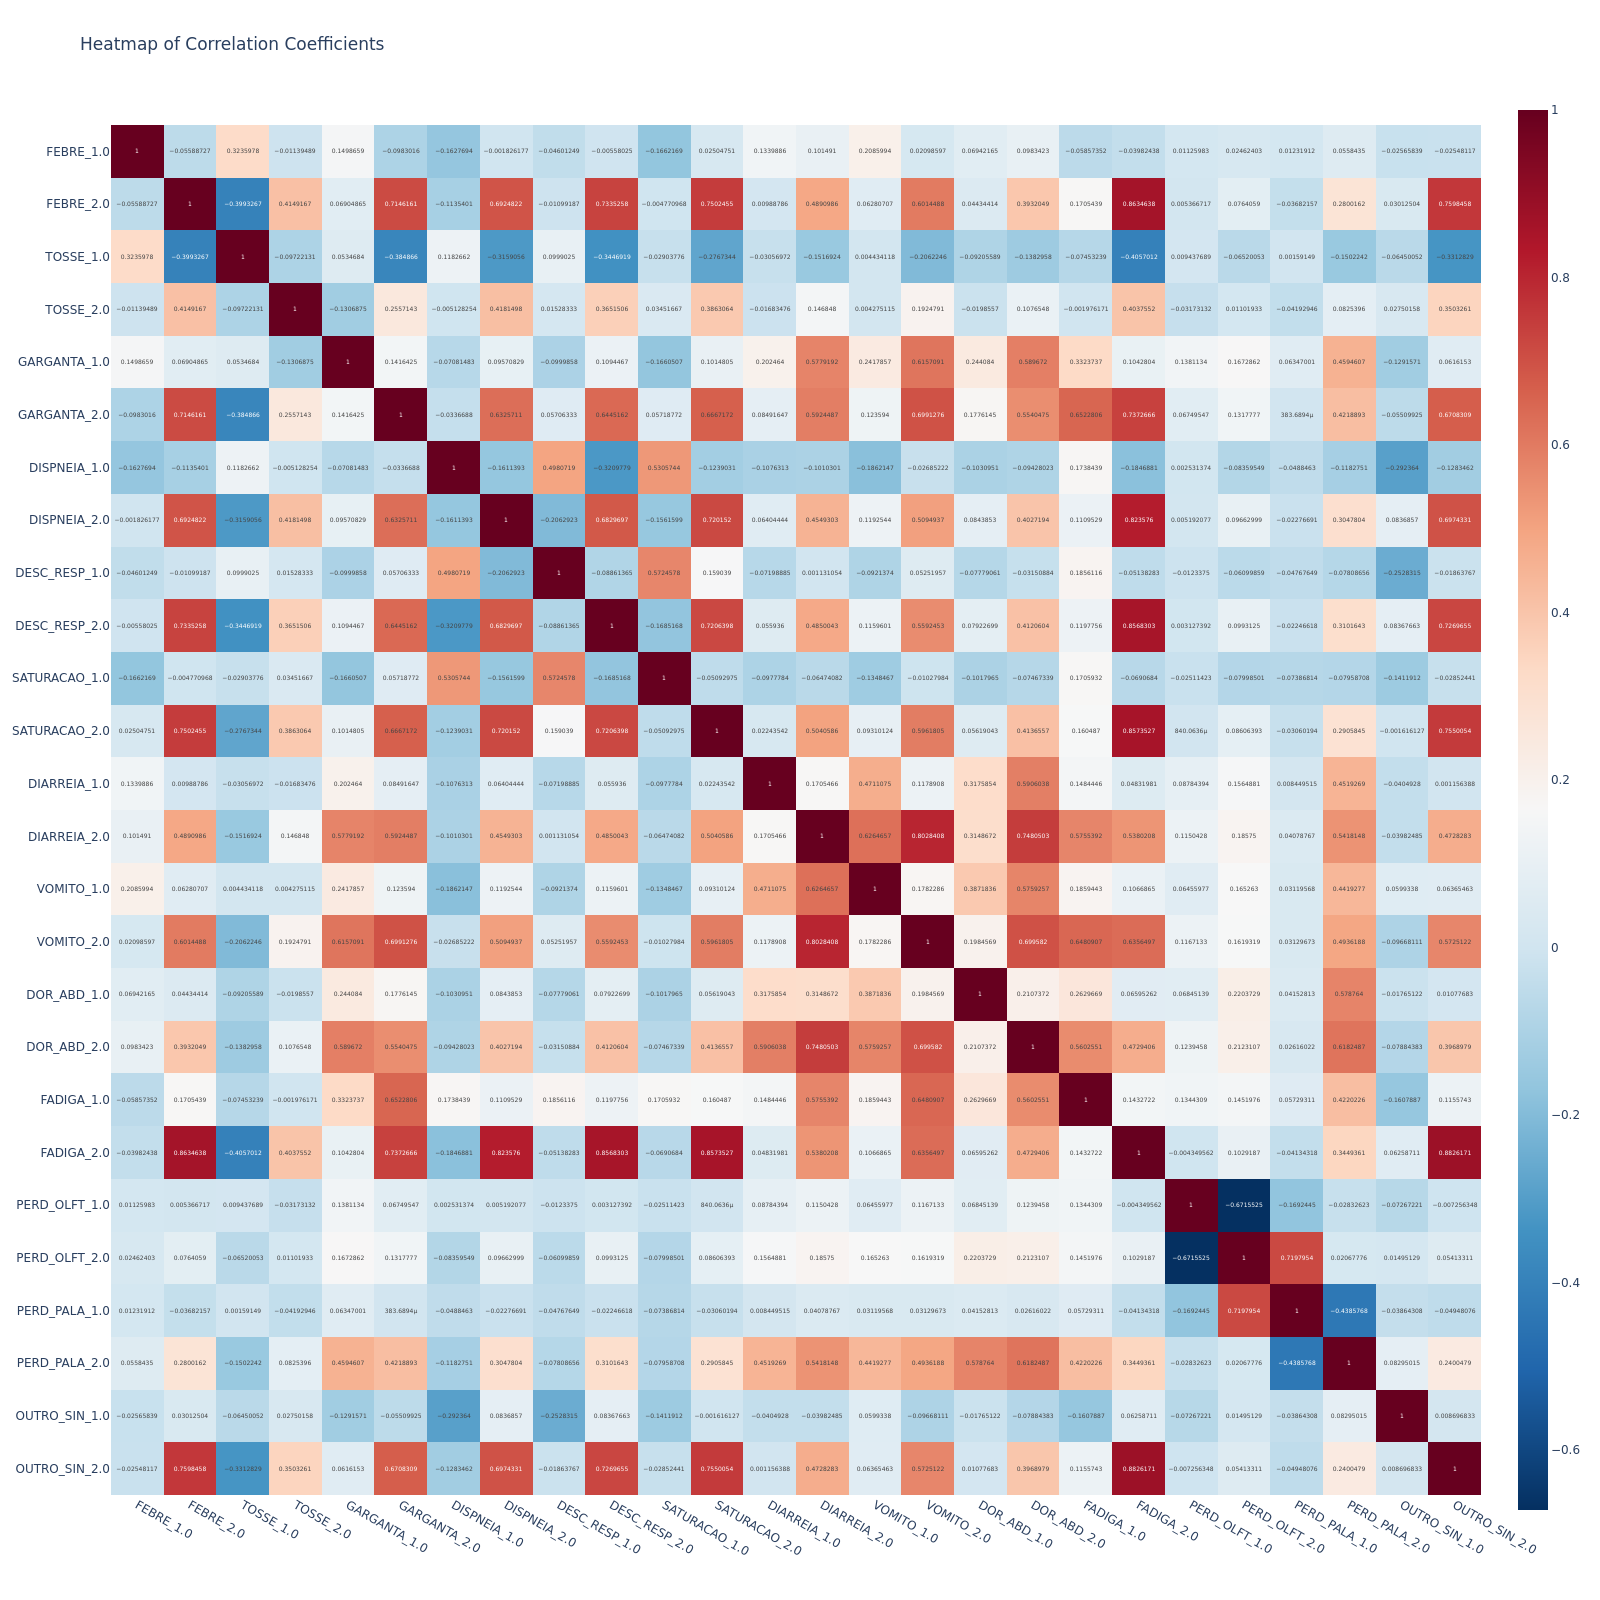

In [301]:
dummy_sintomas = []
for sintoma in sinais_sintomas:
    dummy = df.columns[df.columns.str.startswith(sintoma)]
    dummy_sintomas = dummy_sintomas + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_sintomas)
corr_heatmap(X_train.corr(numeric_only=True)[dummy_sintomas], fig_type="png")

### Fatores de Risco

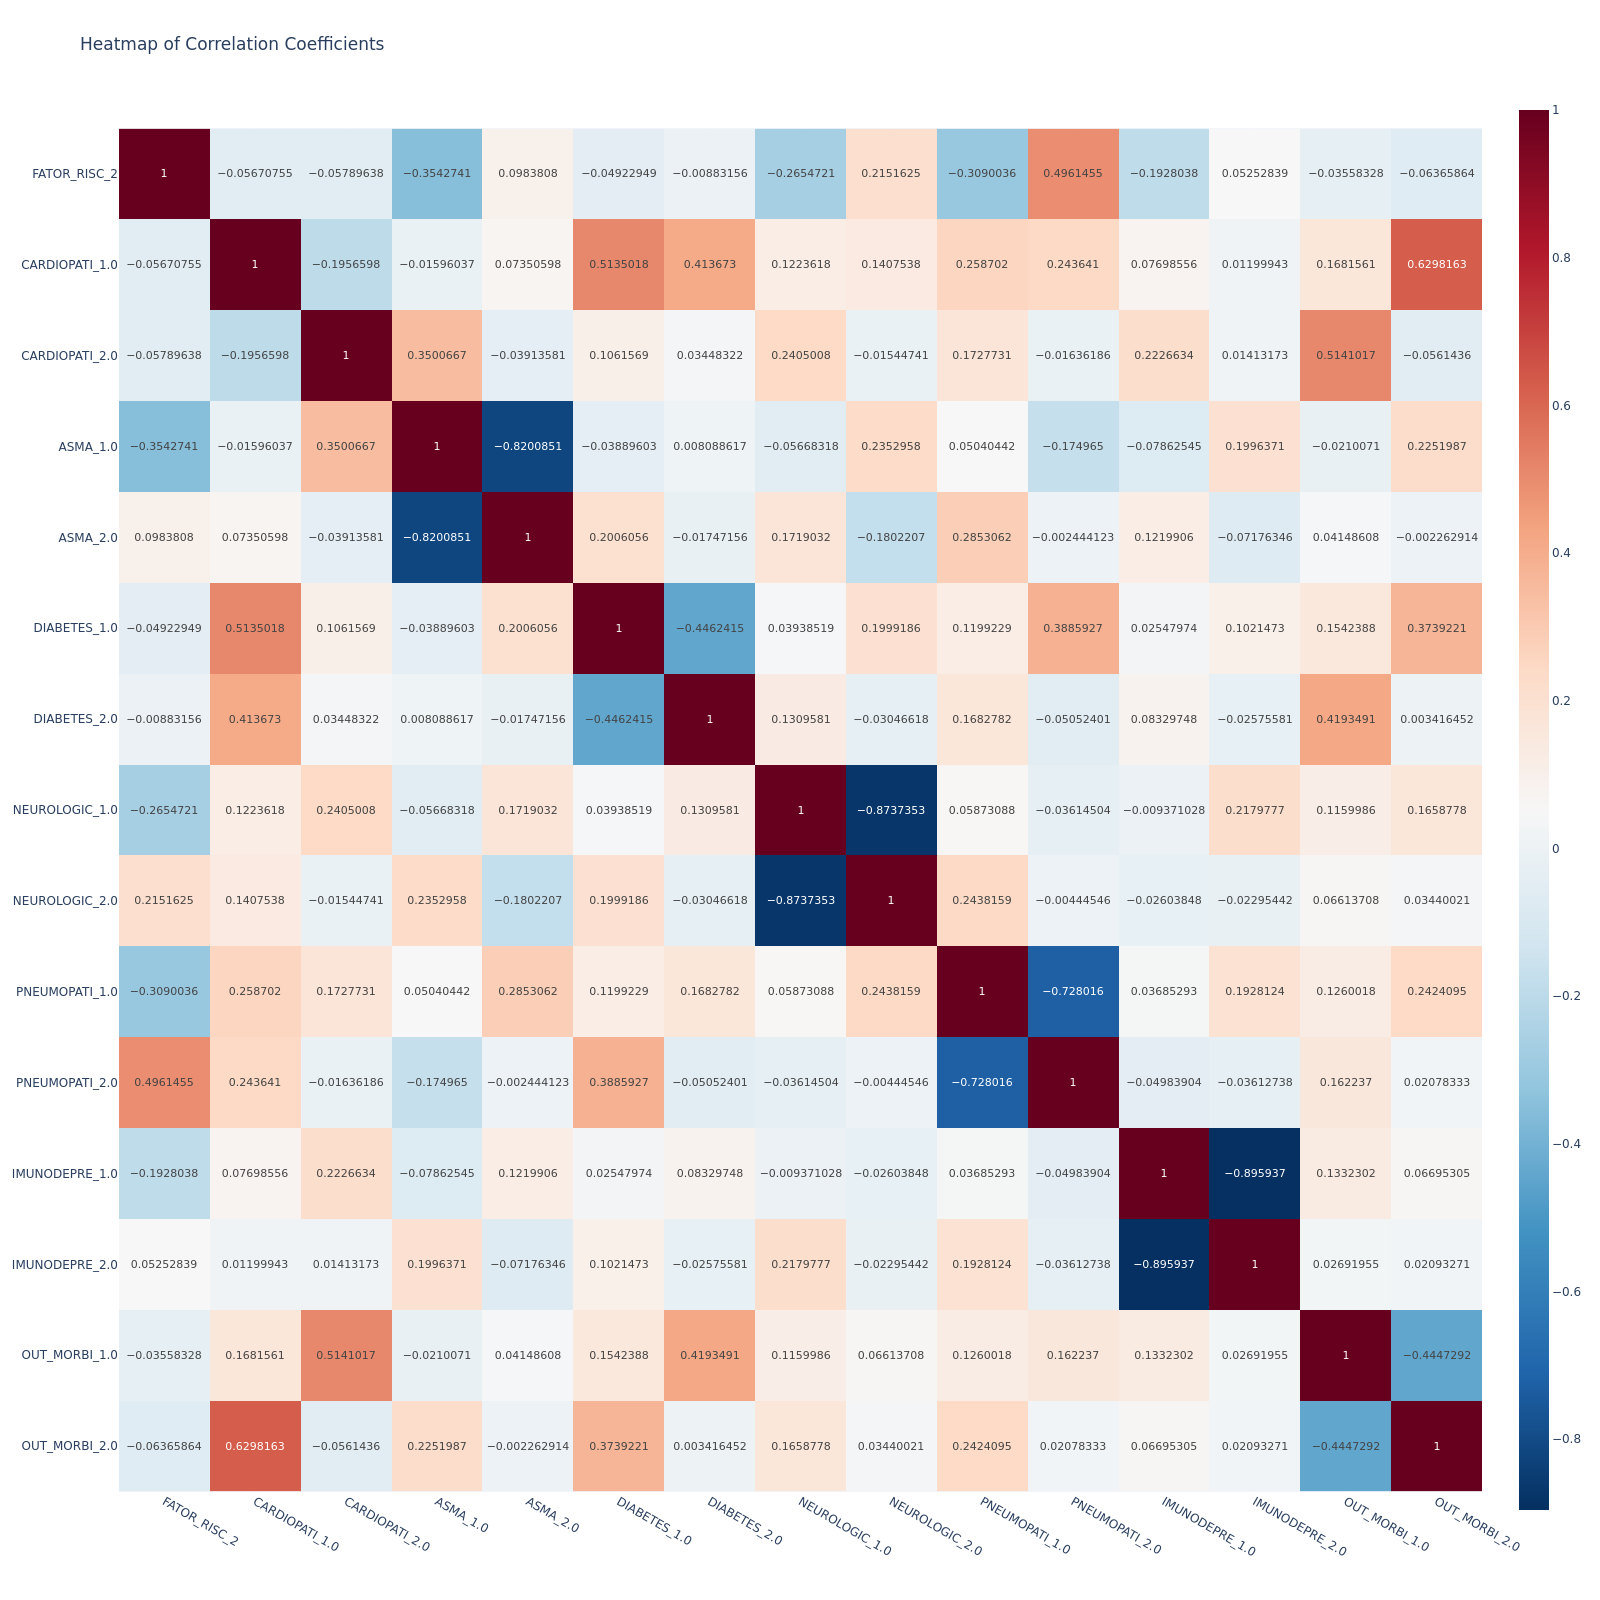

In [302]:
dummy_fatores_risco = []
for fator in fatores_risco:
    dummy = df.columns[df.columns.str.startswith(fator)]
    dummy_fatores_risco = dummy_fatores_risco + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_fatores_risco)

corr_heatmap(X_train.corr(numeric_only=True)[dummy_fatores_risco], fig_type="png")

### Internação

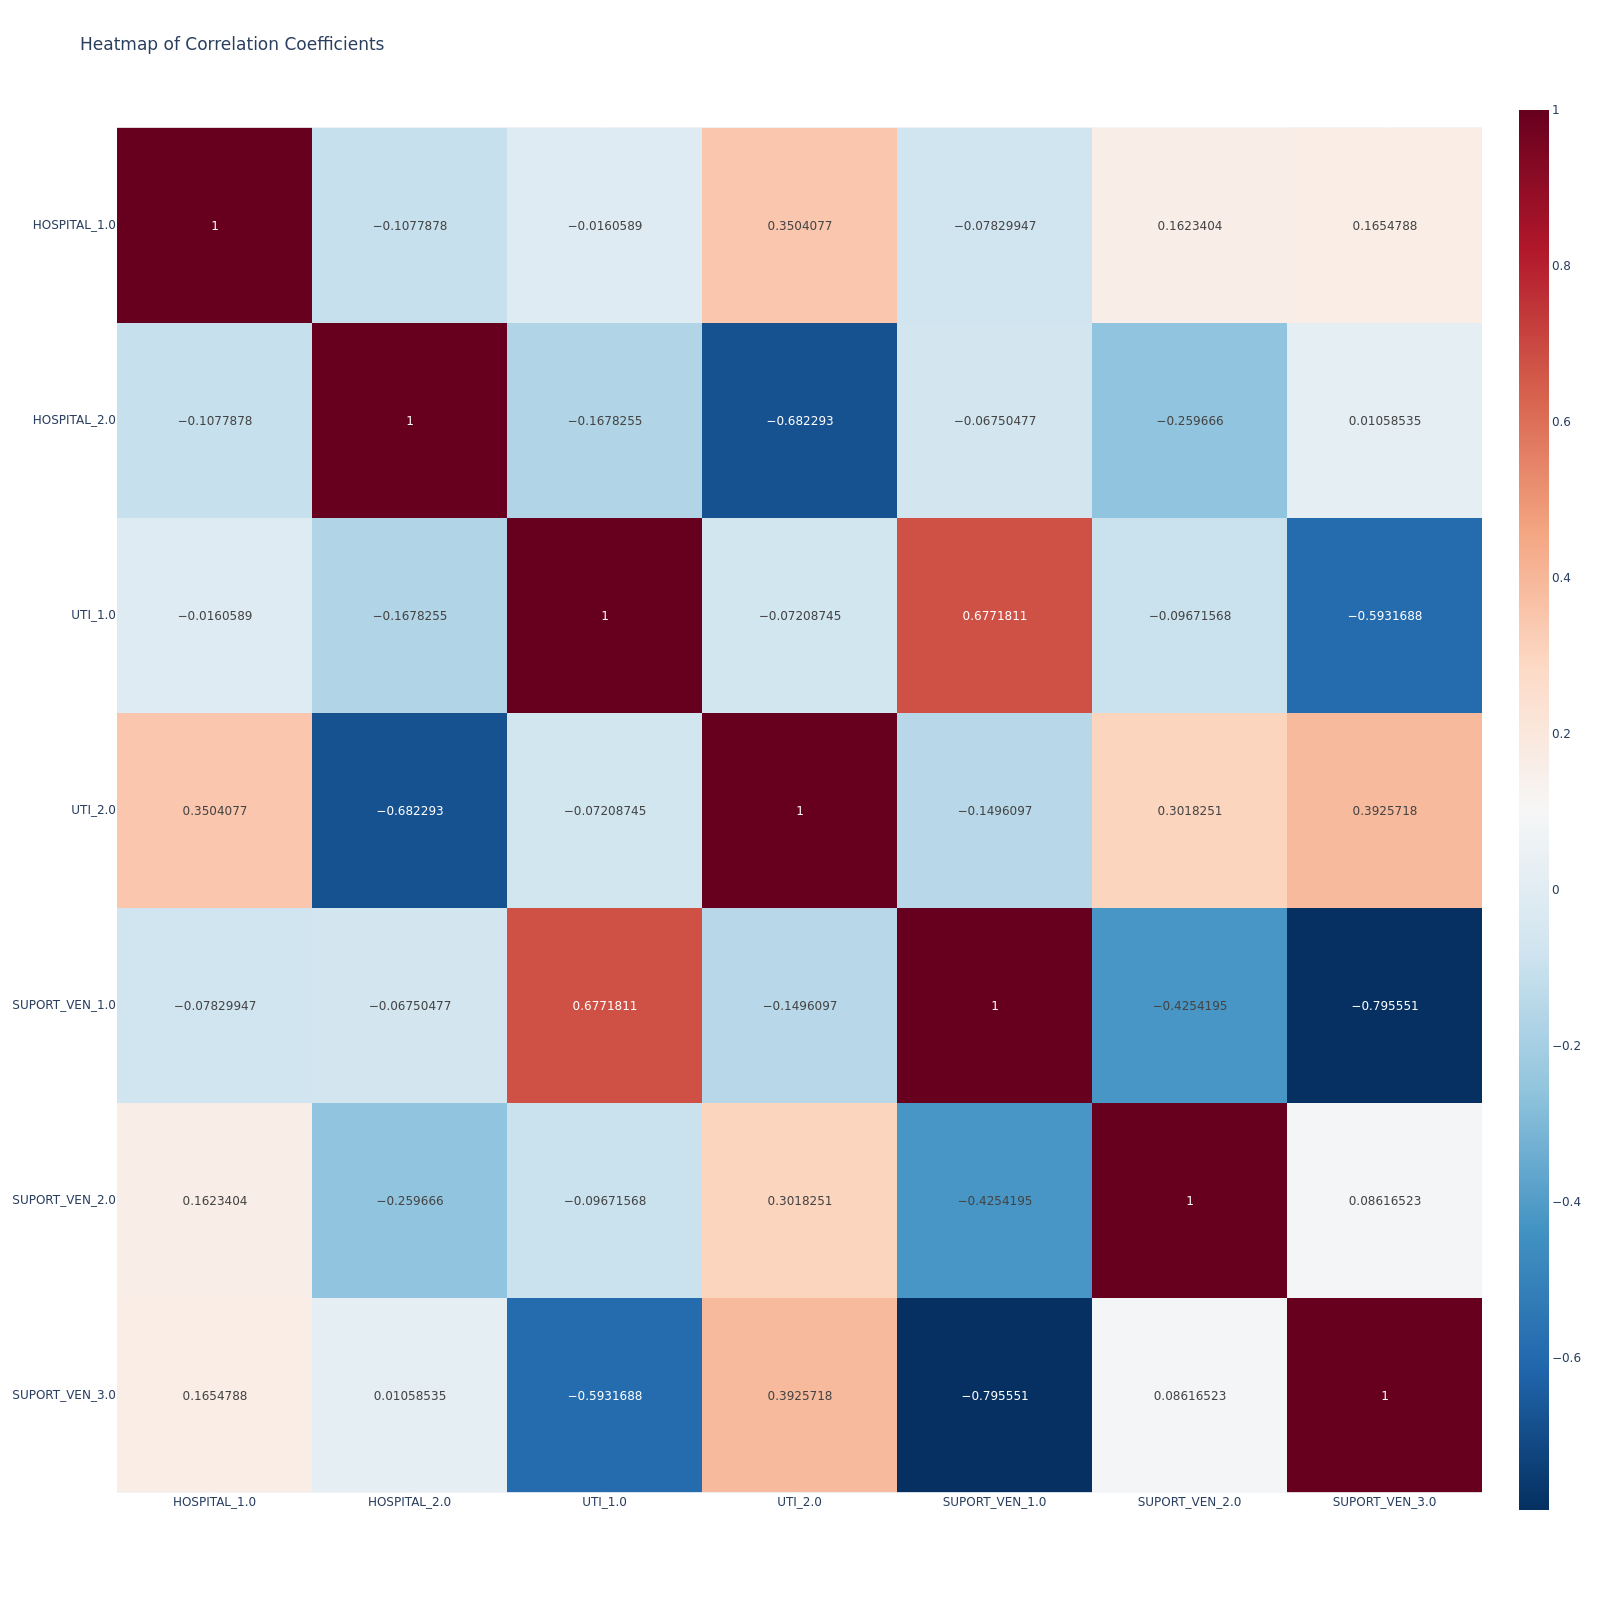

In [303]:
dummy_internacao = []
for inter in internacao:
    dummy = df.columns[df.columns.str.startswith(inter)]
    dummy_internacao = dummy_internacao + dummy.tolist()

residuals_mapping = create_residuals_mapping(dummy_internacao)
corr_heatmap(X_train.corr(numeric_only=True)[dummy_internacao], fig_type="png")

### Heatmap

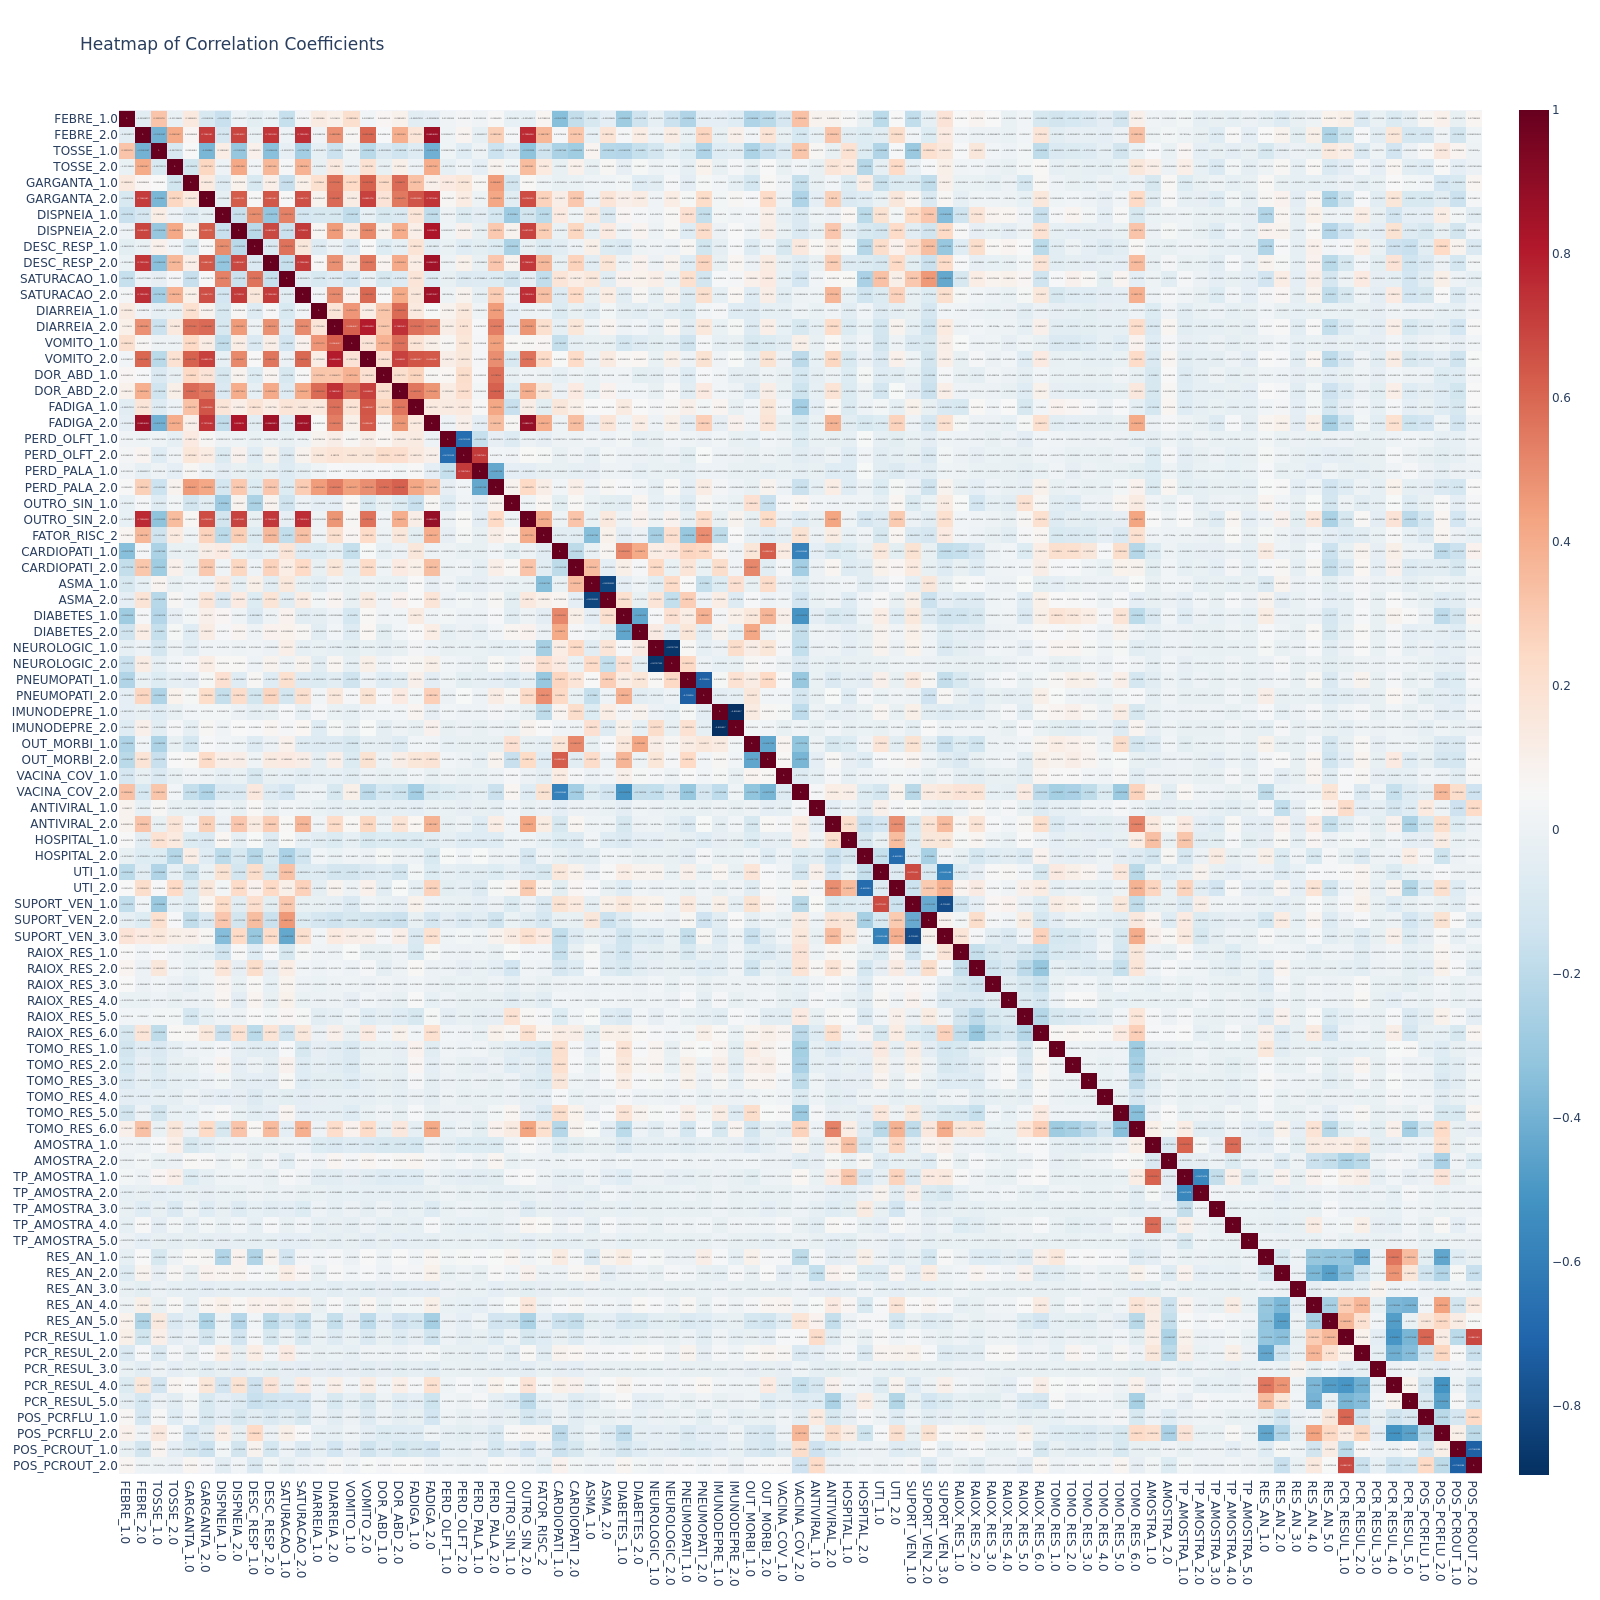

In [304]:
corr_heatmap(X_train.corr(numeric_only=True), fig_type="png")

In [305]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in tqdm(range(features.shape[0])):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [306]:
sample = X_train.sample(40000)
mask_features = filtering_features_based_on_vif(X_train.astype(float), threshold=10)
filtered_features = np.asarray(X_train.columns)[mask_features].tolist()

  0%|          | 0/85 [02:03<?, ?it/s]


In [307]:
def generate_vif_dataframe(df, features):    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    return vif_data

In [308]:
df_vif = generate_vif_dataframe(X_train, filtered_features)

In [309]:
df_vif.sort_values(by="Tolerance")

,feature,VIF,Tolerance
76,PCR_RESUL_1.0,8.990639,0.111227
79,PCR_RESUL_4.0,6.954360,0.143795
84,POS_PCROUT_2.0,6.766592,0.147785
27,CARDIOPATI_1.0,6.515337,0.153484
2,TOSSE_1.0,5.874802,0.170218
...,...,...,...
68,TP_AMOSTRA_3.0,1.029032,0.971787
41,VACINA_COV_1.0,1.026929,0.973778
61,TOMO_RES_4.0,1.017756,0.982554
70,TP_AMOSTRA_5.0,1.006801,0.993245


In [ ]:
filtered_features = ['FEBRE_1.0',
 'FEBRE_2.0',
 'TOSSE_1.0',
 'TOSSE_2.0',
 'GARGANTA_1.0',
 'GARGANTA_2.0',
 'DISPNEIA_1.0',
 'DISPNEIA_2.0',
 'DESC_RESP_1.0',
 'DESC_RESP_2.0',
 'SATURACAO_1.0',
 'SATURACAO_2.0',
 'DIARREIA_1.0',
 'DIARREIA_2.0',
 'VOMITO_1.0',
 'VOMITO_2.0',
 'DOR_ABD_1.0',
 'DOR_ABD_2.0',
 'FADIGA_1.0',
 'FADIGA_2.0',
 'PERD_OLFT_1.0',
 'PERD_OLFT_2.0',
 'PERD_PALA_1.0',
 'PERD_PALA_2.0',
 'OUTRO_SIN_1.0',
 'OUTRO_SIN_2.0',
 'FATOR_RISC_2',
 'CARDIOPATI_1.0',
 'CARDIOPATI_2.0',
 'ASMA_1.0',
 'ASMA_2.0',
 'DIABETES_1.0',
 'DIABETES_2.0',
 'NEUROLOGIC_1.0',
 'NEUROLOGIC_2.0',
 'PNEUMOPATI_1.0',
 'PNEUMOPATI_2.0',
 'IMUNODEPRE_1.0',
 'IMUNODEPRE_2.0',
 'OUT_MORBI_1.0',
 'OUT_MORBI_2.0',
 'VACINA_COV_1.0',
 'VACINA_COV_2.0',
 'ANTIVIRAL_1.0',
 'ANTIVIRAL_2.0',
 'HOSPITAL_1.0',
 'HOSPITAL_2.0',
 'UTI_1.0',
 'UTI_2.0',
 'SUPORT_VEN_1.0',
 'SUPORT_VEN_2.0',
 'SUPORT_VEN_3.0',
 'RAIOX_RES_1.0',
 'RAIOX_RES_2.0',
 'RAIOX_RES_3.0',
 'RAIOX_RES_4.0',
 'RAIOX_RES_5.0',
 'RAIOX_RES_6.0',
 'TOMO_RES_1.0',
 'TOMO_RES_2.0',
 'TOMO_RES_3.0',
 'TOMO_RES_4.0',
 'TOMO_RES_5.0',
 'TOMO_RES_6.0',
 'AMOSTRA_1.0',
 'AMOSTRA_2.0',
 'TP_AMOSTRA_1.0',
 'TP_AMOSTRA_2.0',
 'TP_AMOSTRA_3.0',
 'TP_AMOSTRA_4.0',
 'TP_AMOSTRA_5.0',
 'RES_AN_1.0',
 'RES_AN_2.0',
 'RES_AN_3.0',
 'RES_AN_4.0',
 'RES_AN_5.0',
 'PCR_RESUL_1.0',
 'PCR_RESUL_2.0',
 'PCR_RESUL_3.0',
 'PCR_RESUL_4.0',
 'PCR_RESUL_5.0',
 'POS_PCRFLU_1.0',
 'POS_PCRFLU_2.0',
 'POS_PCROUT_1.0',
 'POS_PCROUT_2.0']

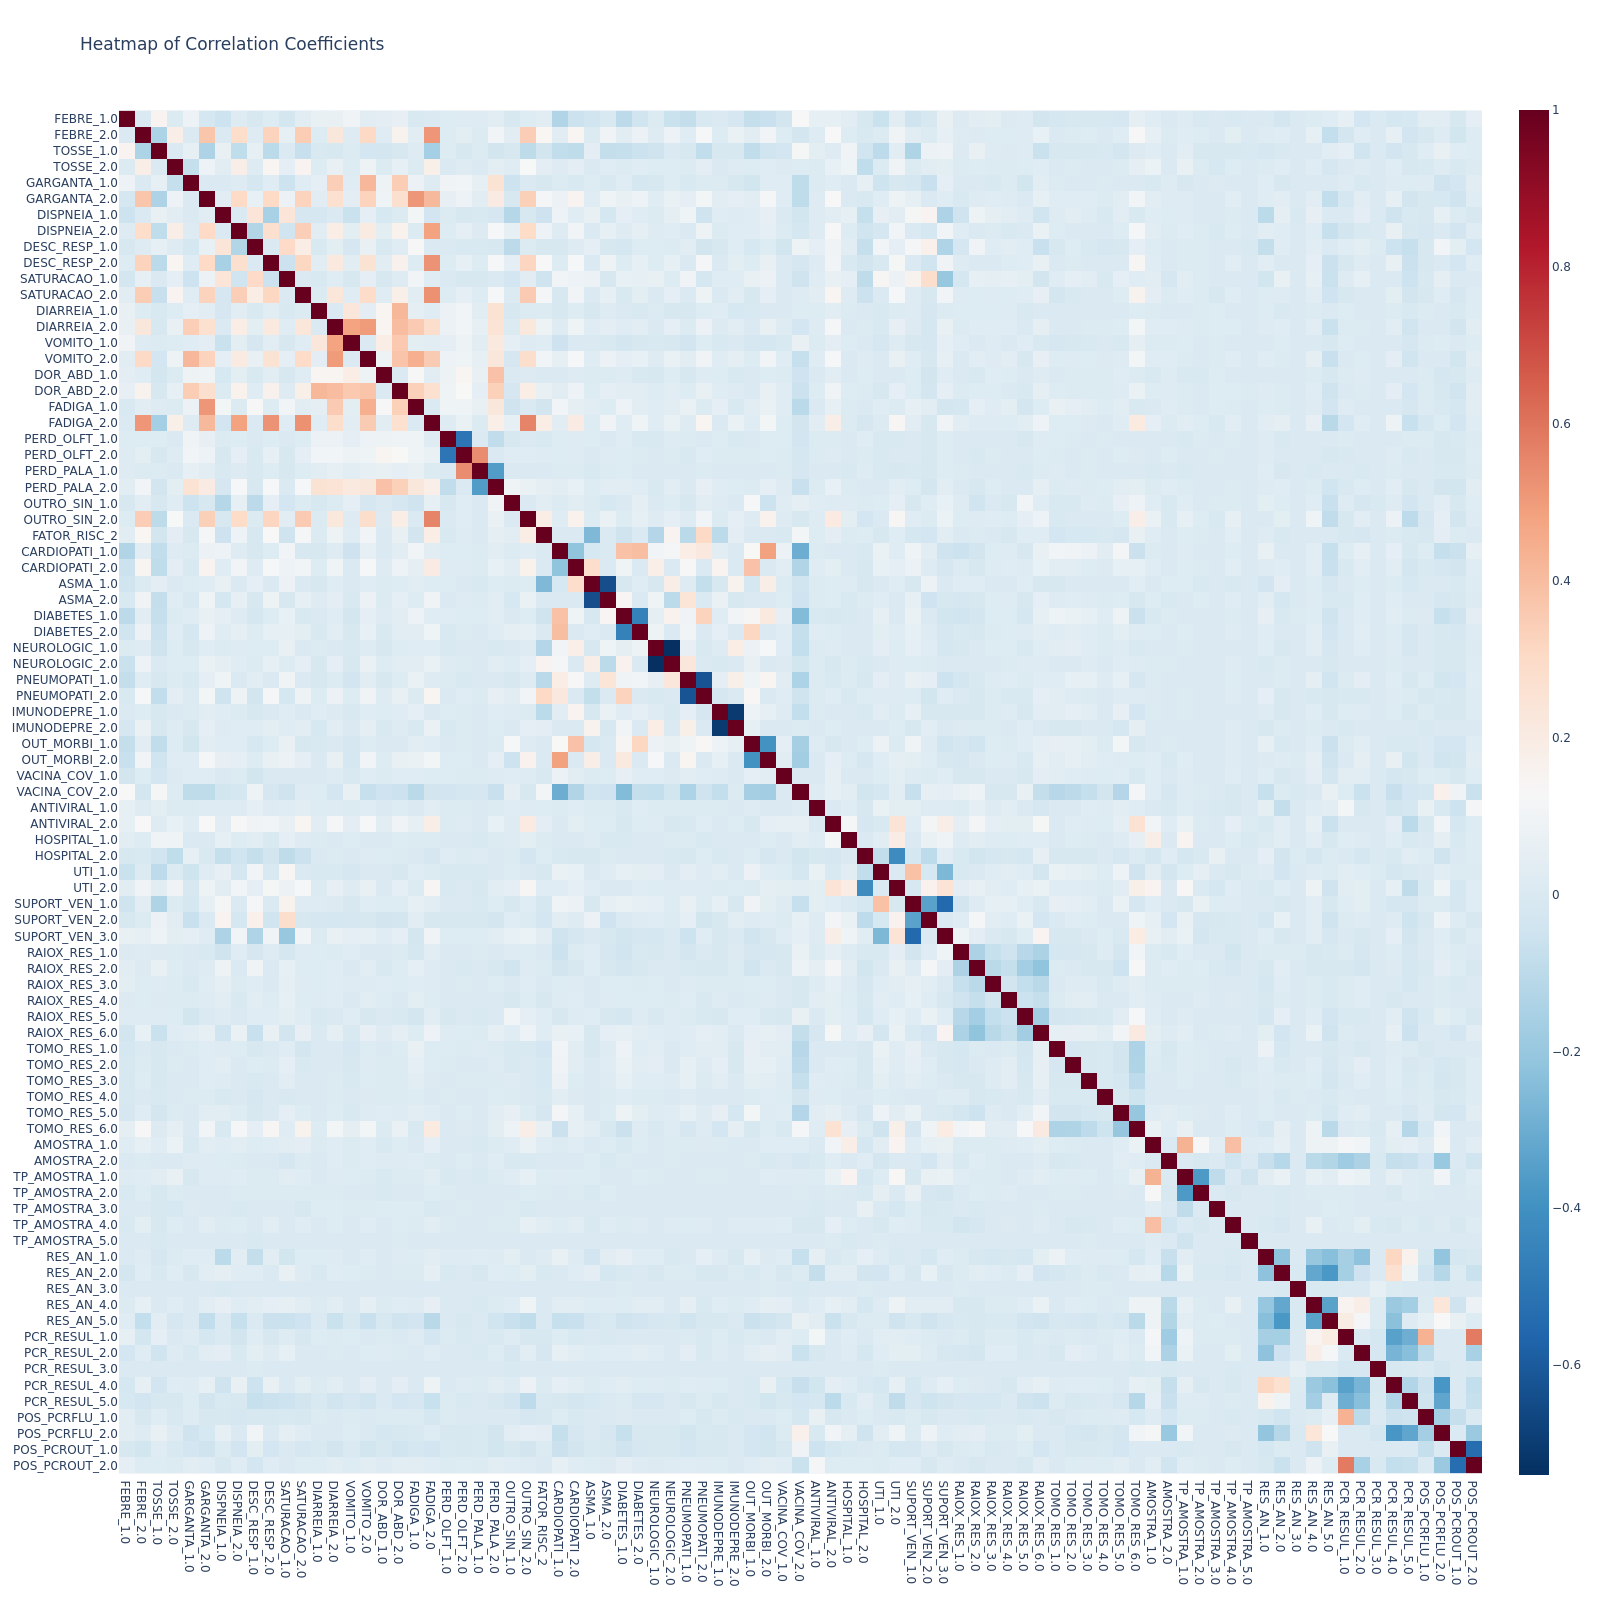

In [240]:
corr_heatmap(X_train[filtered_features], width=1600, height=1600, fig_type="png")

In [241]:
def plot_barplot_corr_with_target(X, y):
    X = X.copy()
    X[target] = y
    corr = X.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

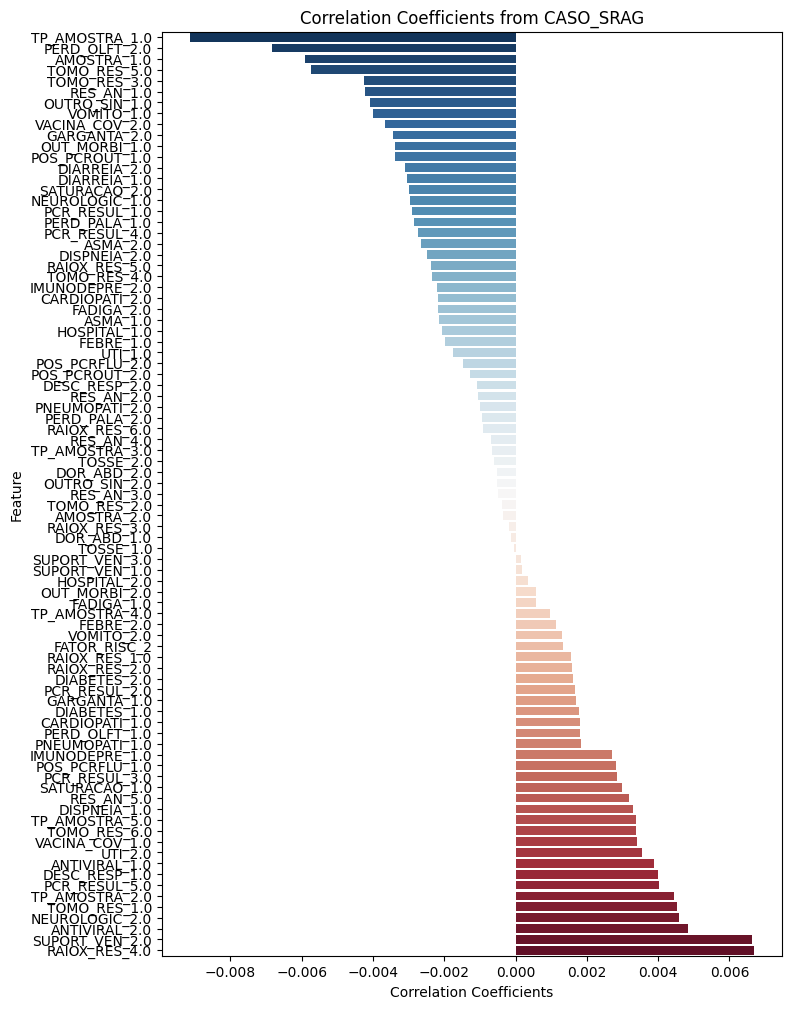

In [242]:
plot_barplot_corr_with_target(X_train[filtered_features], y_train)

# Modelling

In [243]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train[filtered_features], y_train)
model = TunedThresholdClassifierCV(
    model, scoring="matthews_corrcoef"
).fit(X_train[filtered_features], y_train)

In [244]:
matthews_corrcoef(y_test, model.predict(X_test[filtered_features]))

0.9686097923771861

In [245]:
model.best_threshold_

0.34343433836655696

In [246]:
def cm(clf, X, y, fig_type=None, percentage_by_class=True):
    """
    Generates an annotated heatmap of the confusion matrix for a classifier.

    Args:
        clf: Classifier object (e.g., sklearn classifier).
        X: Input features.
        y: True labels.
        alpha: Optional parameter for classifier prediction.
        fig_type: Optional figure type (e.g., 'png', 'svg').
        percentage_by_class: If True, displays percentages by class; otherwise, overall percentages.

    Returns:
        Annotated heatmap of the confusion matrix.
    """

    y_pred = clf.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    labels = np.array([["FN", "TN"], ["TP", "FP"]])
    cm = np.array([[fn, tn], [tp, fp]])

    if percentage_by_class:
        total = cm.sum(axis=0)
        percentage = cm / total * 100
    else:
        percentage = cm / np.sum(cm) * 100

    annotation_text = np.empty_like(percentage, dtype="U10")

    for i in range(percentage.shape[0]):
        for j in range(percentage.shape[1]):
            annotation_text[i, j] = f"{labels[i, j]} {percentage[i, j]:.2f}"

    fig = ff.create_annotated_heatmap(
        cm,
        x=["Positive", "Negative"],
        y=["Negative", "Positive"],
        colorscale="Blues",
        hoverinfo="z",
        annotation_text=annotation_text,
    )

    fig.update_layout(width=400, height=400, title="Confusion Matrix")
    return fig.show(fig_type)

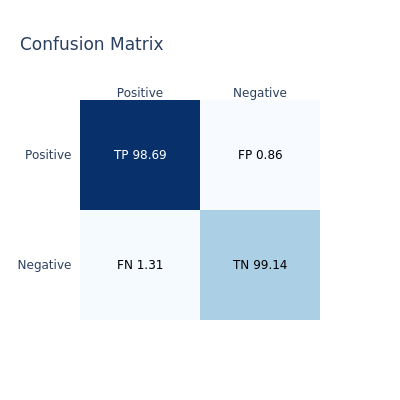

In [247]:
cm(model, X_test[filtered_features], y_test, fig_type="png")

## Análise de resíduo

In [248]:
odd_ratios = np.exp(model.estimator_.coef_)

In [249]:
results = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.estimator_.coef_[0],
    'odd_ratio': np.exp(model.estimator_.coef_[0])
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [250]:
results[results["odd_ratio"] > 1]

,feature,std_coef,odd_ratio
0,TOSSE_1.0,16.554532,1.547184e+07
1,HOSPITAL_1.0,12.899380,4.000641e+05
2,DISPNEIA_1.0,6.176408,4.812603e+02
3,DESC_RESP_1.0,6.151593,4.694647e+02
4,SATURACAO_1.0,4.040238,5.683987e+01
5,GARGANTA_1.0,3.137429,2.304453e+01
6,GARGANTA_2.0,1.915995,6.793696e+00
7,AMOSTRA_1.0,0.842509,2.322187e+00
8,FADIGA_2.0,0.541538,1.718648e+00
9,UTI_2.0,0.514335,1.672526e+00


In [251]:
"""
Aumentam a chance de SRAG:
Internação; (HOSPITAL)
Internação; (UTI)
Apresentar tosse; (TOSSE)
Apresentar DISPNEIA; (DISPNEIA)
Apresentar dor na garganta; (GARGANTA)
Apresentar desconforto respiratório; (DESC_RESP)
Apresentar saturação O2 < 95%; (SATURACAO)
Apresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)
Não apresentar fadiga; (FADIGA)
"""


'\nAumentam a chance de SRAG:\nInternação; (HOSPITAL)\nInternação; (UTI)\nApresentar tosse; (TOSSE)\nApresentar DISPNEIA; (DISPNEIA)\nApresentar dor na garganta; (GARGANTA)\nApresentar desconforto respiratório; (DESC_RESP)\nApresentar saturação O2 < 95%; (SATURACAO)\nApresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)\nNão apresentar fadiga; (FADIGA)\n'

In [252]:
#Remover perda de paladar? Parece que a perda de paladar não 

In [253]:
results[results["odd_ratio"] < 1].sort_values("odd_ratio")

,feature,std_coef,odd_ratio
84,HOSPITAL_2.0,-14.227100,6.625963e-07
83,TOSSE_2.0,-4.571493,1.034250e-02
82,DESC_RESP_2.0,-2.760379,6.326780e-02
81,SATURACAO_2.0,-2.505272,8.165339e-02
80,DISPNEIA_2.0,-1.824784,1.612524e-01
79,FADIGA_1.0,-1.004916,3.660752e-01
78,PCR_RESUL_5.0,-0.734846,4.795795e-01
77,SUPORT_VEN_1.0,-0.719623,4.869357e-01
76,AMOSTRA_2.0,-0.716913,4.882570e-01
75,PCR_RESUL_1.0,-0.642697,5.258725e-01


In [254]:
"""
Diminuem a chance de SRAG:
Paciente não apresentar saturação O2 < 95%
Não apresentar tosse; (TOSSE)
Não houver desconforto respiratório; (DESC_RESP)
Não apresentar dispneia; (DISPNEIA)
Não apresentar dor na garganta; (GARGANTA)
Não apresentar perda do paladar; (PERD_PALA)
Apresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)
Não apresentar fadiga; (FADIGA)
"""

'\nDiminuem a chance de SRAG:\nPaciente não apresentar saturação O2 < 95%\nNão apresentar tosse; (TOSSE)\nNão houver desconforto respiratório; (DESC_RESP)\nNão apresentar dispneia; (DISPNEIA)\nNão apresentar dor na garganta; (GARGANTA)\nNão apresentar perda do paladar; (PERD_PALA)\nApresentar outros sintomas pode não configurar como SRAG; (OUTRO_SIN)\nNão apresentar fadiga; (FADIGA)\n'

In [255]:
X = sm.add_constant(df_train[filtered_features])  # adiciona intercepto
modelo = sm.Logit(df_train[target], df_train[filtered_features]).fit()

modelo.summary()

Optimization terminated successfully.
         Current function value: 0.085490
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              CASO_SRAG   No. Observations:               166144
Model:                          Logit   Df Residuals:                   166059
Method:                           MLE   Df Model:                           84
Date:                Mon, 28 Jul 2025   Pseudo R-squ.:                  0.8476
Time:                        21:11:01   Log-Likelihood:                -14204.
converged:                       True   LL-Null:                       -93198.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
FEBRE_1.0         -0.7104      0.139     -5.102      0.000      -0.983      -0.438
FEBRE_2.0         -0.7896      0.142     -5.563      0.000      -1.068      -0.511
TOSSE_1.0          8.6512      0.161     53.612      0.000       8.335       8.967
TOSSE_2.0         -4.7540      0.150    -31.620      0.000      -5.049      -4.459
GARGANTA_1.0       3.4551      0.113     30.644      0.000       3.234       3.676
GARGANTA_2.0       0.7528      0.108      6.962      0.000       0.541       0.965
DISPNEIA_1.0       1.2386      0.155      7.992      0.000       0.935       1.542
DISPNEIA_2.0      -3.9403      0.162    -24.345      0.000      -4.257      -3.623
DESC_RESP_1.0      0.0691      0.146      0.473      0.636      -0.217       0.355
DESC_RESP_2.0     -4.8457      0.155    -31.289      0.000      -5.149      -4.542
SATURACAO_1.0      0.7199      0.126      5.706      0.000       0.473       0.967
SATURACAO_2.0     -2.9165      0.131    -22.284      0.000      -3.173      -2.660
DIARREIA_1.0       0.4801      0.170      2.832      0.005       0.148       0.812
DIARREIA_2.0       0.4228      0.165      2.559      0.010       0.099       0.746
VOMITO_1.0         0.2632      0.171      1.537      0.124      -0.072       0.599
VOMITO_2.0         0.2974      0.170      1.753      0.080      -0.035       0.630
DOR_ABD_1.0        0.5682      0.173      3.289      0.001       0.230       0.907
DOR_ABD_2.0        0.6848      0.167      4.100      0.000       0.357       1.012
FADIGA_1.0        -0.1437      0.152     -0.947      0.344      -0.441       0.154
FADIGA_2.0         0.0737      0.152      0.484      0.629      -0.225       0.372
PERD_OLFT_1.0      0.1955      0.258      0.758      0.448      -0.310       0.701
PERD_OLFT_2.0      0.0898      0.219      0.411      0.681      -0.339       0.518
PERD_PALA_1.0      0.0678      0.246      0.276      0.783      -0.414       0.549
PERD_PALA_2.0      0.3927      0.202      1.946      0.052      -0.003       0.788
OUTRO_SIN_1.0      0.3762      0.057      6.612      0.000       0.265       0.488
OUTRO_SIN_2.0      0.1962      0.053      3.695      0.000       0.092       0.300
FATOR_RISC_2      -0.6981      0.078     -8.925      0.000      -0.851      -0.545
CARDIOPATI_1.0    -0.1881      0.139     -1.358      0.174      -0.460       0.083
CARDIOPATI_2.0    -0.2941      0.146     -2.014      0.044      -0.580      -0.008
ASMA_1.0           0.0505      0.154      0.327      0.743      -0.252       0.353
ASMA_2.0           0.0121      0.153      0.079      0.937      -0.287       0.312
DIABETES_1.0      -0.3104      0.153     -2.031      0.042      -0.610      -0.011
DIABETES_2.0      -0.2486      0.160     -1.555      0.120      -0.562       0.065
NEUROLOGIC_1.0    -0.0470      0.166     -0.283      0.777      -0.373       0.279
NEUROLOGIC_2.0     0.0143      0.171      0.084      0.933      -0.321       0.349
PNEUMOPATI_1.0     0.5303      0.184      2.876      0.004       0.169       0.892
PNEU

# RandomForestClassifier

In [256]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
model.fit(X_train[filtered_features], y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,17
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [257]:
model = TunedThresholdClassifierCV(
    model, scoring="matthews_corrcoef"
).fit(X_train[filtered_features], y_train)

In [258]:
matthews_corrcoef(y_test, model.predict(X_test[filtered_features]))

0.9947297486496117

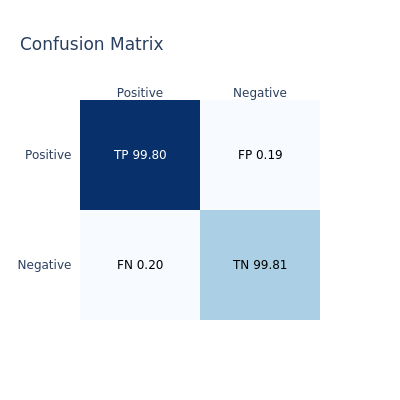

In [259]:
cm(model, X_test[filtered_features], y_test, fig_type="png")

In [260]:
results = pd.DataFrame({
    'feature': model.feature_names_in_,
    'feature_importance': model.estimator.feature_importances_,
}).sort_values(by='feature_importance', ascending=False).reset_index(drop=True)
results.head(15)

,feature,feature_importance
0,TOSSE_2.0,0.274812
1,TOSSE_1.0,0.259332
2,DISPNEIA_2.0,0.069910
3,DISPNEIA_1.0,0.060672
4,SATURACAO_2.0,0.057684
5,DESC_RESP_2.0,0.056859
6,DESC_RESP_1.0,0.050190
7,SATURACAO_1.0,0.033117
8,HOSPITAL_1.0,0.023280
9,HOSPITAL_2.0,0.014833
